In [ ]:
import os

In [63]:
from pydantic import BaseModel
import time
from typing import Literal
from itertools import batched
from rich import print
from rich.progress import track
from huggingface_hub import InferenceClient
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
token = os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [3]:

client = InferenceClient(token=token)

In [4]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/palewire/first-llm-classifier/refs/heads/main/_notebooks/Form460ScheduleESubItem.csv"
)

In [5]:
class PayeeList(BaseModel):
    answers: list[Literal["Restaurant", "Bar", "Hotel", "Other"]]

In [73]:
def classify_payees(name_list, model):
    prompt = """
You are an AI model trained to categorize businesses based on their names.

You will be given a list of business names, each separated by a new line.

Your task is to analyze each name and classify it into one of the following categories: Restaurant, Bar, Hotel, or Other.

If a business does not clearly fall into Restaurant, Bar, or Hotel categories, you should classify it as "Other".

Even if the type of business is not immediately clear from the name, it is essential that you provide your best guess based on the information available to you. If you can't make a good guess, classify it as Other.

For example, if given the following input:

"Intercontinental Hotel\nPizza Hut\nCheers\nWelsh's Family Restaurant\nKTLA\nDirect Mailing"

Your output should be a JSON object in the following format:

{"answers": ["Hotel", "Restaurant", "Bar", "Restaurant", "Other", "Other"]}

This means that you have classified "Intercontinental Hotel" as a Hotel, "Pizza Hut" as a Restaurant, "Cheers" as a Bar, "Welsh's Family Restaurant" as a Restaurant, and both "KTLA" and "Direct Mailing" as Other.
"""

    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": prompt,
            },
            {
                "role": "user",
                "content": "Intercontinental Hotel\nPizza Hut\nCheers\nWelsh's Family Restaurant\nKTLA\nDirect Mailing",
            },
            {
                "role": "assistant",
                "content": '{"answers": ["Hotel", "Restaurant", "Bar", "Restaurant", "Other", "Other"]}',
            },
            {
                "role": "user",
                "content": "Subway Sandwiches\nRuth Chris Steakhouse\nPolitical Consulting Co\nThe Lamb's Club",
            },
            {
                "role": "assistant",
                "content": '{"answers": ["Restaurant", "Restaurant", "Other", "Bar"]}',
            },
            {
                "role": "user",
                "content": "\n".join(name_list),
            },
        ],
        model=model,
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "PayeeList",
                "schema": PayeeList.model_json_schema()
            }
        },
        temperature=0,
    )

    result = PayeeList.model_validate_json(response.choices[0].message.content)
    return dict(zip(name_list, result.answers))

In [7]:
sample_list = list(df.sample(10).payee)

In [8]:
classify_payees(sample_list)

{'THE FARM': 'Restaurant',
 'SOUTWEST AIRLINES': 'Other',
 'CULINARY SPECIALTIES': 'Other',
 'MARRIOTT HOTEL SAN DIEGO MARINA': 'Hotel',
 'CHOPS STEAKHOUSE AND SEAFOOD': 'Restaurant',
 'PRELUDE KITCHEN & BAR': 'Bar',
 'JOANN WILSON': 'Other',
 'COMFORT SUITES': 'Hotel',
 "BALLY'S HOTEL": 'Hotel',
 'DOORDASH, INC.': 'Other'}

In [72]:
def classify_batches(name_list, model, batch_size=10, wait=1):
    """Split the provided list of names into batches and classify with our LLM them one by one."""
    # Create a place to store the results
    all_results = {}

    # Create an list that will split the name_list into batches
    batch_list = list(batched(list(name_list), batch_size))

    # Loop through the list in batches
    for batch in track(batch_list, description="Classifying batches..."):
        # Classify it with the LLM
        batch_results = classify_payees(list(batch), model)

        # Verify that we got back the same number of results as we sent in
        try:
            assert len(batch_results) == len(batch)
        except AssertionError:
            raise AssertionError(f"Expected {len(batch)} results but got back {len(batch_results)}.")

        # Add what we get back to the results
        all_results.update(batch_results)

        # Tap the brakes to avoid overloading Hugging Face's API
        time.sleep(wait)

    # Return the results
    return pd.DataFrame(all_results.items(), columns=["payee", "category"])

In [50]:
bigger_sample = list(df.sample(100).payee)

In [51]:
results_df = classify_batches(bigger_sample)

Output()

In [29]:
print(results_df.sample(10).reset_index(drop=True).to_markdown())

|    | payee                               | category   |
|---:|:------------------------------------|:-----------|
|  0 | PETE'S CAFE                         | Restaurant |
|  1 | ALAMO RENT-A-CAR SANTA ANA          | Other      |
|  2 | COMMITTEE TO ELECT ELENA            | Other      |
|  3 | FAIRMONT SAN JOSE                   | Hotel      |
|  4 | BEST WESTERN HOTELS SAN SIMEON      | Hotel      |
|  5 | VAROGA RICEW & SHALETT, INC.        | Other      |
|  6 | EL SEGUNDO HERALD                   | Other      |
|  7 | MCI                                 | Other      |
|  8 | TIKAL RESTAURANT                    | Restaurant |
|  9 | PEREA FOR SCCCD TRUSTEE AREA 5 2018 | Other      |

In [34]:
print(df.sample(10).reset_index().to_markdown())

|    |   index | payee                               |
|---:|--------:|:------------------------------------|
|  0 |   14901 | THE STATIONERY STUDIO               |
|  1 |    1389 | BELL WINE AND SPIRITS               |
|  2 |   10472 | NEWSOM FOR CALIFORNIA GOVERNOR 2022 |
|  3 |   11301 | PASADENA JOURNAL NEWS               |
|  4 |    3133 | CLEARMAN'S STEAK AND STEIN          |
|  5 |    4606 | EL SAUZ TACOS                       |
|  6 |    5491 | FRIENDS OF MARK TWAIN MIDDLE SCHOOL |
|  7 |    5050 | FAT CITY                            |
|  8 |   11294 | PARVINDER KANG - PETTY CASHIER      |
|  9 |   11410 | PEARL'S CAFE                        |

In [35]:
sample_df = pd.read_csv(
    "https://raw.githubusercontent.com/palewire/first-llm-classifier/refs/heads/main/_notebooks/sample.csv"
)

In [38]:
training_input, test_input, training_output, test_output = train_test_split(
    sample_df[["payee"]],
    sample_df["category"],
    test_size=0.67,
    random_state=42,  # Remember Jackie Robinson. Remember Douglas Adams.
)

In [61]:
llm_df = classify_batches(list(test_input.payee))

Output()

In [62]:
print(classification_report(test_output, llm_df.category))

precision    recall  f1-score   support

         Bar       0.25      1.00      0.40         2
       Hotel       0.90      1.00      0.95        18
       Other       0.99      0.93      0.96       112
  Restaurant       0.91      0.89      0.90        36

    accuracy                           0.93       168
   macro avg       0.76      0.95      0.80       168
weighted avg       0.96      0.93      0.94       168

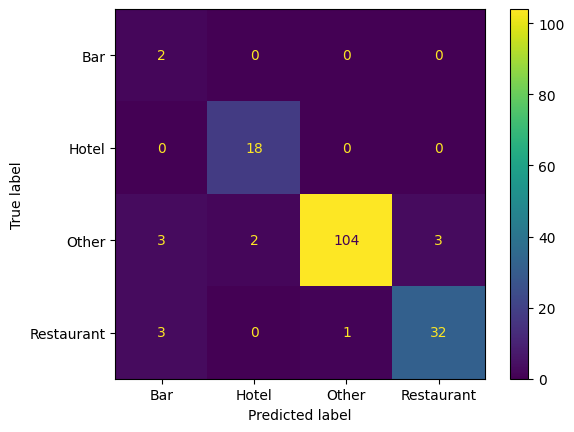

In [64]:
ConfusionMatrixDisplay.from_predictions(test_output, llm_df.category)

In [65]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm="l2",
    encoding="latin-1",
    ngram_range=(1, 3),
)
preprocessor = ColumnTransformer(
    transformers=[("payee", vectorizer, "payee")], sparse_threshold=0, remainder="drop"
)
pipeline = Pipeline(
    [("preprocessor", preprocessor), ("classifier", LinearSVC(dual="auto"))]
)

In [67]:
model = pipeline.fit(training_input, training_output)

In [68]:
predictions = model.predict(test_input)

In [70]:
print(classification_report(test_output, predictions))

/Users/U6122976/Code/first-llm-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/U6122976/Code/first-llm-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/U6122976/Code/first-llm-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

precision    recall  f1-score   support

         Bar       0.00      0.00      0.00         2
       Hotel       0.00      0.00      0.00        18
       Other       0.67      1.00      0.80       112
  Restaurant       0.00      0.00      0.00        36

    accuracy                           0.67       168
   macro avg       0.17      0.25      0.20       168
weighted avg       0.44      0.67      0.53       168

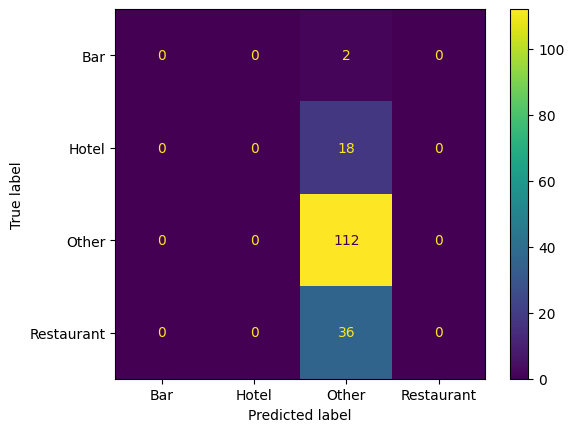

In [71]:
ConfusionMatrixDisplay.from_predictions(test_output, predictions)

In [94]:
model_list = [
    #"meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    #"google/gemma-3-27b-it",
    "Qwen/Qwen3-235B-A22B-Instruct-2507",
]

In [95]:
for m in model_list:
    print(f"Model: {m}")
    result_df = classify_batches(test_input.payee, m)
    print(classification_report(test_output, result_df.category))

Model: Qwen/Qwen3-235B-A22B-Instruct-2507

Output()

precision    recall  f1-score   support

         Bar       0.40      1.00      0.57         2
       Hotel       0.86      1.00      0.92        18
       Other       0.99      0.93      0.96       112
  Restaurant       0.89      0.92      0.90        36

    accuracy                           0.93       168
   macro avg       0.78      0.96      0.84       168
weighted avg       0.95      0.93      0.94       168